In [1]:
import numpy as np
import os
import glob
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import pandas as pd

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

/home/sha_maayan/python-environments/env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# This is needed to display the images.
%matplotlib inline

In [3]:
from utils import label_map_util
from utils import visualization_utils as vis_util

/home/sha_maayan/APIs/models/research/object_detection/utils/visualization_utils.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/sha_maayan/python-environments/env/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/sha_maayan/python-environments/env/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/sha_maayan/python-environments/env/lib/python3.5/site-packages/ipykernel/kerne

In [4]:
MODEL_PATH = '/home/sha_maayan/busProject/6_classes/models/ssd_inception_v2_coco_2017_11_17/fold2/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = os.path.join(MODEL_PATH, 'frozen_inference_graph.pb')

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join(MODEL_PATH, 'label_map.pbtxt')

NUM_CLASSES = 6

In [5]:
# load frozen model
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [6]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [7]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [8]:
# test train images
PATH_TO_AUG_IMAGES = '/home/sha_maayan/busProject/6_classes/augmentation/aug_images/'
PATH_TO_ORIGINAL_IMAGES = '/home/sha_maayan/busProject/6_classes/images/'
PATH_TO_ANNO = '/home/sha_maayan/busProject/6_classes/annotations/'

df_test = pd.read_csv(os.path.join(PATH_TO_ANNO, 'bus_anno_aug_test_fold2.csv'))
test_images = list(set((df_test['path']+df_test['filename']).tolist()))

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [9]:
# test reseized images
test_images = glob.glob(os.path.join(PATH_TO_ORIGINAL_IMAGES,'ssd_resized/') + '*JPG')

In [10]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

{'detection_boxes': array([[0.568221  , 0.25616887, 0.8374777 , 0.6177565 ],
       [0.296728  , 0.112885  , 0.89270806, 0.84901536],
       [0.51612866, 0.942716  , 0.8933064 , 1.        ],
       [0.568221  , 0.25616887, 0.8374777 , 0.6177565 ],
       [0.5470356 , 0.93148834, 0.9418299 , 1.        ],
       [0.568221  , 0.25616887, 0.8374777 , 0.6177565 ]], dtype=float32), 'num_detections': 6, 'detection_scores': array([9.9997532e-01, 4.5383545e-03, 3.3756739e-03, 1.7366359e-03,
       1.6794717e-03, 3.4971168e-04], dtype=float32), 'detection_classes': array([6, 1, 3, 5, 4, 2], dtype=uint8)}
{'detection_boxes': array([[0.467412  , 0.07144997, 0.6968303 , 0.3889274 ],
       [0.49493855, 0.46005824, 0.7197599 , 0.77891576],
       [0.46025816, 0.07896835, 0.6947378 , 0.39746842],
       [0.46025816, 0.07896835, 0.6947378 , 0.39746842],
       [0.88653135, 0.44816542, 0.975132  , 0.5407913 ],
       [0.46025816, 0.07896835, 0.6947378 , 0.39746842]], dtype=float32), 'num_detections': 6

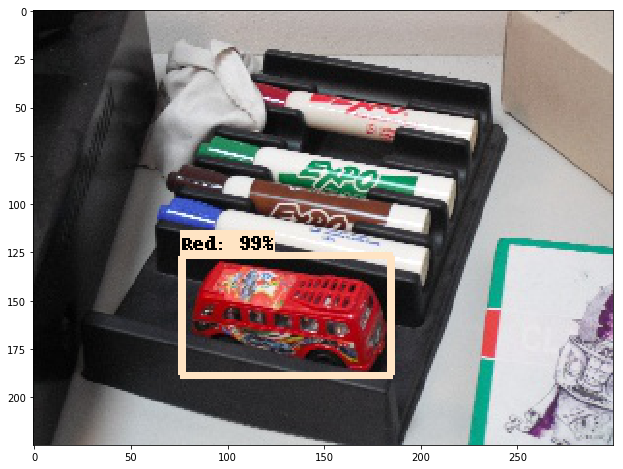

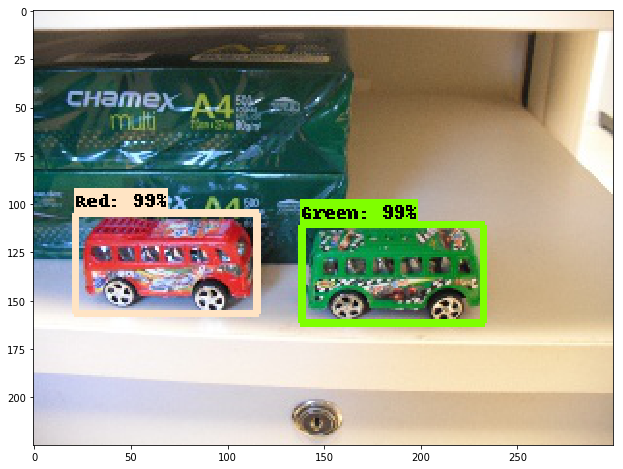

In [11]:
for image_path in test_images[:2]:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      min_score_thresh=.2,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=4)
    print(output_dict)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)